In [1]:
#!pip freeze

In [27]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import holidays
import utils
import seaborn as sns

from skrub import TableVectorizer
from scipy.stats import uniform, randint

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
)
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

Evaluate

In [67]:
%matplotlib inline
sns.set_theme()  # Apply the default theme of seaborn
plt.rcParams["figure.figsize"] = (10, 4)  # Set the figure size for all plots

## Import the data

In [4]:
train_data = pd.read_parquet(Path("data") / "train.parquet")
train_data.set_index("date", inplace=True)

external_data = pd.read_csv(Path("data") / "external_data.csv")
external_data["date"] = pd.to_datetime(external_data["date"])
external_data.set_index("date", inplace=True)

## Data Preprocessing


### Removing duplicate rows
Only external_data has duplicated rows.

In [5]:
# Remove duplicates and keep first occurance
external_data.drop_duplicates(keep="first", inplace=True)

### Handling Missing Values
Only external_data has missing values.

#### Option 1: Drop features with >=50% missing values

In [6]:
threshold = 0.5
bool_drop = external_data.isna().mean() >= threshold

dropped_feat_ext = external_data.columns[bool_drop]
selected_feat_ext = external_data.columns[~bool_drop]

external_data.drop(dropped_feat_ext, axis=1, inplace=True)

print(f"Features dropped: {len(dropped_feat_ext)}")
print(dropped_feat_ext)

Features dropped: 20
Index(['niv_bar', 'geop', 'tn12', 'tn24', 'tx12', 'tx24', 'tminsol', 'sw',
       'tw', 'phenspe1', 'phenspe2', 'phenspe3', 'phenspe4', 'ctype2',
       'nnuage3', 'ctype3', 'hnuage3', 'nnuage4', 'ctype4', 'hnuage4'],
      dtype='object')


### Handling Outliers
We identify outliers by IQR method and remove them accordingly.

In [7]:
# Selecting the numerical columns with the np.number type
df_train_numerical = train_data.select_dtypes(include=np.number)
df_train_numerical.head()

,site_id,bike_count,latitude,longitude,log_bike_count
date,,,,,
2020-09-01 02:00:00,100007049,0.0,48.846028,2.375429,0.000000
2020-09-01 03:00:00,100007049,1.0,48.846028,2.375429,0.693147
2020-09-01 04:00:00,100007049,0.0,48.846028,2.375429,0.000000
2020-09-01 15:00:00,100007049,4.0,48.846028,2.375429,1.609438
2020-09-01 18:00:00,100007049,9.0,48.846028,2.375429,2.302585


In [8]:
# Selecting the numerical columns with the np.number type
df_external_numerical = external_data.select_dtypes(include=np.number)
df_external_numerical.head()

,numer_sta,pmer,tend,cod_tend,dd,ff,t,td,u,vv,...,rr1,rr3,rr6,rr12,rr24,nnuage1,ctype1,hnuage1,nnuage2,hnuage2
date,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,7149,100810,80,1,270,1.8,272.75,272.15,96,990,...,0.0,0.0,0.0,0.0,2.0,1.0,6.0,600.0,NaN,NaN
2021-01-01 03:00:00,7149,100920,110,3,300,1.7,271.25,270.95,98,210,...,0.0,0.0,0.0,0.0,1.2,1.0,6.0,1500.0,2.0,3000.0
2021-01-01 06:00:00,7149,100950,30,3,290,2.6,271.95,271.65,98,3660,...,0.0,0.0,0.0,0.0,1.0,3.0,6.0,480.0,4.0,2000.0
2021-01-01 09:00:00,7149,101100,150,2,280,1.7,272.45,272.05,97,3500,...,0.0,0.2,0.2,0.2,0.2,1.0,6.0,1740.0,3.0,2800.0
2021-01-01 12:00:00,7149,101110,30,0,50,1.0,276.95,274.15,82,8000,...,0.0,0.0,0.2,0.2,0.2,1.0,8.0,330.0,4.0,570.0


In [73]:
# Original number of observations
print("Train data", train_data.shape)
print("External data", external_data.shape)

Train data (496827, 11)
External data (3321, 38)


In [74]:
# Remove outliers for training data
train_data = remove_outliers_iqr(train_data, df_train_numerical)
train_data.shape

(431964, 11)

In [75]:
# Remove outliers for external data
external_data = remove_outliers_iqr(external_data, df_external_numerical)
external_data.shape

(166, 38)

## Merge datasets based on Date

In [9]:
# Upsample to hourly frequency
# 3 methods: forward fill, backward fill, linear interpolation
# external_data_resampled = external_data.resample('h').ffill()
# external_data_resampled = external_data.resample('h').bfill()
# external_data_resampled = external_data.resample("h").interpolate(method="linear")
external_data_resampled = external_data.resample("h").interpolate(
    method="time"
)  # Best way to do it

# Reset index if needed
external_data_resampled = external_data_resampled.reset_index()

In [10]:
train_merged = pd.merge(train_data, external_data_resampled, how="inner", on="date")
train_merged

,date,counter_id,counter_name,site_id,site_name,bike_count,counter_installation_date,coordinates,counter_technical_id,latitude,...,rr1,rr3,rr6,rr12,rr24,nnuage1,ctype1,hnuage1,nnuage2,hnuage2
0,2020-09-01 12:00:00,100036718-104036718,39 quai François Mauriac NO-SE,100036718,39 quai François Mauriac,73.0,2017-07-12,"48.83436,2.377",Y2H17021629,48.83436,...,0.0,0.0,0.0,0.0,0.0,1.500000,8.000000,1325.000000,3.000000,3400.000000
1,2020-09-01 19:00:00,100036718-104036718,39 quai François Mauriac NO-SE,100036718,39 quai François Mauriac,78.0,2017-07-12,"48.83436,2.377",Y2H17021629,48.83436,...,0.0,0.0,0.0,0.0,0.0,1.333333,6.666667,1833.333333,3.666667,2366.666667
2,2020-09-01 20:00:00,100036718-104036718,39 quai François Mauriac NO-SE,100036718,39 quai François Mauriac,67.0,2017-07-12,"48.83436,2.377",Y2H17021629,48.83436,...,0.0,0.0,0.0,0.0,0.0,1.166667,6.333333,1866.666667,3.333333,2383.333333
3,2020-09-02 03:00:00,100036718-104036718,39 quai François Mauriac NO-SE,100036718,39 quai François Mauriac,5.0,2017-07-12,"48.83436,2.377",Y2H17021629,48.83436,...,0.0,0.0,0.0,0.0,0.0,1.666667,6.000000,1855.000000,3.000000,2460.000000
4,2020-09-02 09:00:00,100036718-104036718,39 quai François Mauriac NO-SE,100036718,39 quai François Mauriac,65.0,2017-07-12,"48.83436,2.377",Y2H17021629,48.83436,...,0.0,0.0,0.0,0.0,0.0,2.333333,6.000000,1810.000000,3.000000,2520.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431622,2021-09-09 12:00:00,100063175-353277235,20 Avenue de Clichy SE-NO,100063175,20 Avenue de Clichy,127.0,2020-07-22,"48.88529,2.32666",Y2H20073268,48.88529,...,0.0,0.0,0.0,0.0,0.0,2.153846,7.538462,1487.692308,4.000000,3338.461538
431623,2021-09-09 13:00:00,100063175-353277235,20 Avenue de Clichy SE-NO,100063175,20 Avenue de Clichy,114.0,2020-07-22,"48.88529,2.32666",Y2H20073268,48.88529,...,0.0,0.0,0.0,0.0,0.0,2.217949,7.512821,1485.897436,4.000000,3412.820513
431624,2021-09-09 14:00:00,100063175-353277235,20 Avenue de Clichy SE-NO,100063175,20 Avenue de Clichy,153.0,2020-07-22,"48.88529,2.32666",Y2H20073268,48.88529,...,0.0,0.0,0.0,0.0,0.0,2.282051,7.487179,1484.102564,4.000000,3487.179487
431625,2021-09-09 15:00:00,100063175-353277235,20 Avenue de Clichy SE-NO,100063175,20 Avenue de Clichy,186.0,2020-07-22,"48.88529,2.32666",Y2H20073268,48.88529,...,0.0,0.0,0.0,0.0,0.0,2.346154,7.461538,1482.307692,4.000000,3561.538462


## Feature Selection

In [11]:
# Features of train.paquet
selected_columns = [
    "counter_technical_id",
    "latitude",
    "longitude",
    "counter_id",
    "site_id",
    "date",
]

dropped_columns = [
    "counter_name",
    "site_name",
    "bike_count",
    "counter_installation_date",
    "coordinates",
]

## Feature Engineering

#### Encode dates

In [12]:
def _encode_dates(X):
    lockdown_periods = (
        ["17-03-2020", "11-05-2020"],
        ["30-10-2020", "15-12-2020"],
        ["03-04-2021", "03-05-2021"],
    )

    lockdown_periods = [
        [pd.to_datetime(start, dayfirst=True), pd.to_datetime(end, dayfirst=True)]
        for start, end in lockdown_periods
    ]

    X = X.copy()  # modify a copy of X

    # Encode the date information from the date column
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday + 1
    X["hour"] = X["date"].dt.hour

    X["is_weekend"] = (X["weekday"] > 5).astype(int)
    X["is_holiday"] = (
        X["date"].apply(lambda x: 1 if x in holidays.FR() else 0).astype(int)
    )
    X["is_lockdown"] = (
        X["date"].apply(
            lambda x: any(start <= x <= end for start, end in lockdown_periods)
        )
    ).astype(int)

    return X.drop(columns=["date"])

In [13]:
train_merged = _encode_dates(train_merged)

KeyboardInterrupt: 

### Rescale

### Encode 

#### Encode Weather

## Selecting features with ANOVA

# Modelling
1. SGD Regressor (<100k samples)
2. Lasso / ElasticNet (>100k samples + few features should be important)
3. RidgeRegression / SVR(kernel='linear') (>100k samples + many features should be important)

Data for modelling

In [14]:
train_columns = [
    "counter_id",
    # "site_id",
    # "counter_technical_id",
    "latitude",
    "longitude",
    "is_holiday",
    "year",
    "month",
    "day",
    "weekday",
    "hour",
    "is_weekend",
    "ff",  #: "Vitesse_du_vent_moyen_10mn",
    "t",  #: "Température_K",
    # "u",  #: "humidity", # Correlated with 'Temps_présent' (ww, w1, w2) and "État_du_sol" (etat_sol)
    "vv",  #: "visibility_h",
    "ww",  #: "Temps_présent",
    # "w1",  #: "Temps_passé_1", # Correlated with w2 and ww so kept ww
    # "w2",  #: "Temps_passé_2", # Correlated with w1 and ww so kept ww
    "n",  #: "Nebulosité_totale", #
    "etat_sol",  #: "État_du_sol",
    "ht_neige",  #: "Hauteur_totale_neige",
    "rr1",  #: "Précipitations_1h",
    # "rr3",  #: "Précipitations_3h",   # Correlated with each other so only took rr1
    # "rr6",  #: "Précipitations_6h",   # Correlated with each other so only took rr1
    # "rr12",  #: "Précipitations_12h", # Correlated with each other so only took rr1
    # "rr24",  #: "Précipitations_24h",  # Not so correlated with rr1 but info in etat_sol so kept etat_sol
]

In [15]:
X = train_merged[train_columns]
y = train_merged["log_bike_count"]

Train-test split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Model with Vectorized Table

In [17]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "k-Nearest Neighbors": KNeighborsRegressor(),
    "Hist Grad Boosting Tree": HistGradientBoostingRegressor(),
}

In [18]:
models_accuracy = {}
for name, model in models.items():
    model_i = make_pipeline(TableVectorizer(), model)
    # Train the model
    model_i.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model_i.predict(X_test)

    # Evaluate the model
    accuracy = root_mean_squared_error(y_test, y_pred)
    models_accuracy[name] = accuracy
    print(f"{name}: RMSE = {accuracy:.2f}")

/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From 

Linear Regression: RMSE = 1.65


/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From 

Ridge Regression: RMSE = 1.33


/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From 

Lasso Regression: RMSE = 1.51


/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From 

Decision Tree: RMSE = 0.53


/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From 

Random Forest: RMSE = 0.37


/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From 

k-Nearest Neighbors: RMSE = 1.08


/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Hist Grad Boosting Tree: RMSE = 0.48


/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


/var/folders/pj/s8thlv2s5ls_9mngg8y0qvq00000gn/T/ipykernel_93293/3760302168.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="RMSE", data=df, palette="Blues_d")


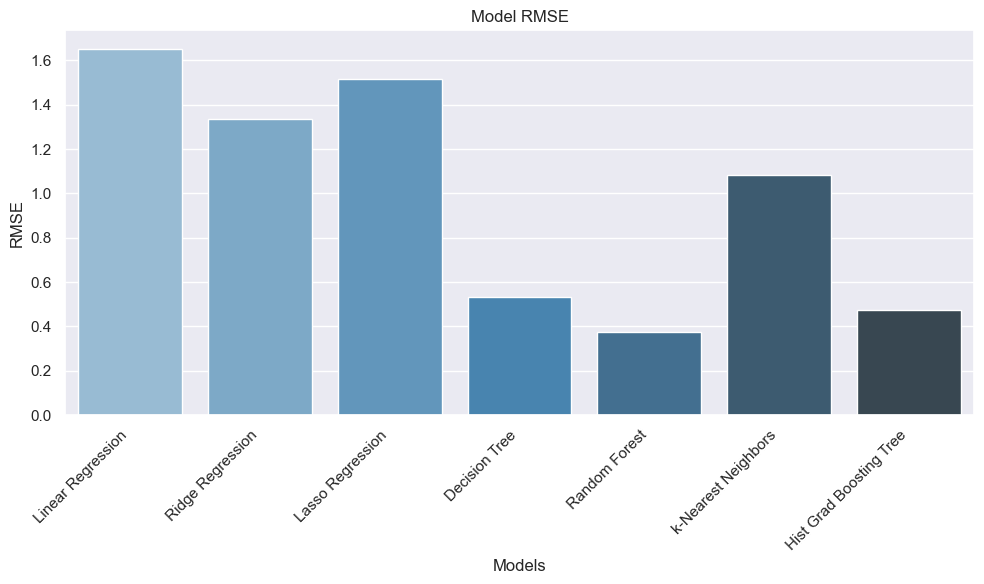

In [20]:
# Convert dictionary to DataFrame
df = pd.DataFrame(list(models_accuracy.items()), columns=["Model", "RMSE"])

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="RMSE", data=df, palette="Blues_d")

# Customize the plot
plt.xticks(rotation=45, ha="right")  # Rotate model names for better readability
plt.title("Model RMSE")
plt.xlabel("Models")
plt.ylabel("RMSE")
plt.tight_layout()

# Show the plot
plt.show()

In [28]:
# Random Forest
model = make_pipeline(TableVectorizer(), RandomForestRegressor())

## Define the parameter grid for RandomForestRegressor
# param_grid = {
#    "randomforestregressor__max_depth": np.arange(10, 101, 10),
#    "randomforestregressor__min_samples_split": [2, 4, 8, 10, 12],
#    "randomforestregressor__min_samples_leaf": [1, 3, 4, 5],
# }
#
## Perform GridSearchCV
# model_grid_search = GridSearchCV(
#    model, param_grid=param_grid, n_jobs=-1, cv=5,
#    scoring='neg_root_mean_squared_error'
# )

# Define the parameter grid distribtuion for RandomForestRegressor
param_distributions = {
    "randomforestregressor__max_depth": randint(10, 50),
    "randomforestregressor__n_estimators": randint(10, 100),
}

model_grid_search = RandomizedSearchCV(
    model,
    param_distributions=param_distributions,
    n_iter=5,
    n_jobs=-1,
    cv=5,
    random_state=3010,
)
model_grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print(f"The best set of parameters is: {model_grid_search.best_params_}")
print(f"The best cross-validation RMSE score is: {abs(model_grid_search.best_score_)}")

/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From 

The best set of parameters is: {'randomforestregressor__max_depth': 29, 'randomforestregressor__n_estimators': 95}
The best cross-validation RMSE score is: 0.9459163862068852


Fit the model 

In [ ]:
# model = make_pipeline(TableVectorizer(), RandomForestRegressor())
model = model_grid_search.best_estimator_
model.fit(X_train, y_train)

Evaluate

In [20]:
print(f"Train set, RMSE={root_mean_squared_error(y_train, model.predict(X_train)):.2f}")
print(f"Valid set, RMSE={root_mean_squared_error(y_test, model.predict(X_test)):.2f}")

/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From 

Train set, RMSE=0.14
Valid set, RMSE=0.37


/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [21]:
rmse = root_mean_squared_error(y_test, model.predict(X_test))
print(f"Root Mean Squared Error: {rmse}")

test_data = pd.read_parquet(Path("data") / "final_test.parquet")
test_data_merged = test_data.merge(external_data_resampled, on="date", how="inner")
test_data_merged = _encode_dates(test_data_merged)[X.columns]
# test_data_merged = test_data_merged[X_train.columns]

/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From 

Root Mean Squared Error: 0.3745292193821957


In [23]:
submission = model.predict(test_data_merged[X.columns])
print(submission.shape)
pd.Series(submission).to_frame().rename_axis("Id").rename(
    columns={0: "log_bike_count"}
).to_csv("submission9_081224.csv")

(51440,)


/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
